## Лабораторная работа 2
- логистическая регрессия для классификации спама
- линейная регрессия для предсказания рейтинга фильма

### Импорт библиотек

В этом блоке я подключаю все нужные библиотеки которые использую в лабораторной работе

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge


## Метрики
Объяснение взял с первой лабы:

### Классификация (спам / не спам)
Класс spam (спам) обычно меньше, чем ham (не спам), поэтому accuracy мало
Использую такие метрики по классу spam:

- Accuracy - доля правильно классифицированных сообщений
- Precision - из всех найденных моделью спам‑сообщений, сколько реально из них попало, то есть реальный спам
- Recall - из всех настоящих спамов, сколько модель нашла успешно
- F1 - баланс между precision и recall. я считаю, что это основная метрика для сравнения моделей тут

### Регрессия (рейтинг фильма)
Предсказать числовой рейтинг (0.5–5.0) (в реальности были бы пол звезды и 5 звезд), поэтому беру:

- MAE (Mean Absolute Error) - средняя абсолютная ошибка, легко интерпретируется.
- RMSE - корень из MSE (чем сильнее промах, тем еще больше будет штраф)
- R² - доля объяснённой дисперсии (чем ближе к 1, тем лучше).


## Классификация SMS - логистическая регрессия

В этом блоке я загружаю датасет со спам сообщениями из файла spam.csv. При чтении я выбираю только два нужных столбца это метка сообщения и сам текст. Потом я переименовываю их чтобы с ними удобно работать дальше.

In [ ]:
spam_path = "/content/spam.csv"
spam_df = pd.read_csv(spam_path, encoding="latin1")[["v1", "v2"]]
spam_df.columns = ["label", "message"]
print("Размер датасета:", spam_df.shape)
display(spam_df.head())
print("\nРаспределение классов:")
print(spam_df["label"].value_counts())

Размер датасета: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



Распределение классов:
label
ham     4825
spam     747
Name: count, dtype: int64


Здесь я делю датасет на тексты сообщений и их метки. Затем с помощью train_test_split разделяю данные на обучение и тест. Stratify используется чтобы пропорция спама и не спама сохранялась. В конце вывожу размеры выборок.

In [ ]:
X = spam_df["message"]
y = spam_df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Обучающая выборка:", len(X_train))
print("Тестовая выборка:", len(X_test))

Обучающая выборка: 4457
Тестовая выборка: 1115


### Логистическая регрессия

Здесь я создаю базовую модель логистической регрессии. Сначала текст преобразуется в числа через TF-IDF потом логистическая регрессия учится на этих данных. После обучения я делаю предсказания на тестовой выборке и считаю основные метрики качества.

Я вывожу accuracy precision recall и F1 чтобы увидеть насколько хорошо модель ловит спам. Затем строю матрицу ошибок чтобы наглядно посмотреть где модель ошибалась.

=== Базовая логистическая регрессия ===
Accuracy : 0.9677
Precision: 1.0000
Recall   : 0.7584
F1 (spam): 0.8626

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



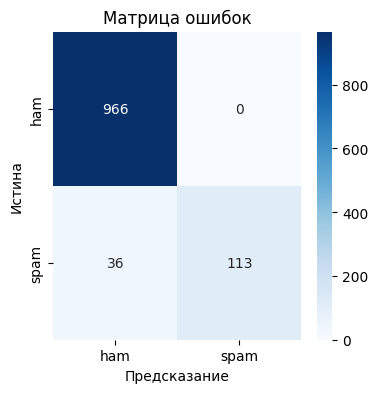

In [ ]:
log_reg_base = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("logreg", LogisticRegression(max_iter=1000, solver="liblinear"))
])
log_reg_base.fit(X_train, y_train)
y_pred_base = log_reg_base.predict(X_test)

acc_base = accuracy_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base, pos_label="spam")
rec_base = recall_score(y_test, y_pred_base, pos_label="spam")
f1_base = f1_score(y_test, y_pred_base, pos_label="spam")

print("=== Базовая логистическая регрессия ===")
print(f"Accuracy : {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")
print(f"Recall   : {rec_base:.4f}")
print(f"F1 (spam): {f1_base:.4f}\n")
print(classification_report(y_test, y_pred_base))

cm_base = confusion_matrix(y_test, y_pred_base, labels=["ham","spam"])
plt.figure(figsize=(4,4))
sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues",
            xticklabels=["ham","spam"], yticklabels=["ham","spam"])
plt.xlabel("Предсказание")
plt.ylabel("Истина")
plt.title("Матрица ошибок")
plt.show()

### Улучшенная логистическая регрессия

### Гипотезы как можно улучшить модели:

- выполнить масштабирование признаков, чтобы все признаки были в одном масштабе

- использовать регуляризацию и подобрать параметр C или alpha

- ограничить количество признаков max_features, чтобы избежать переобучения

- подобрать параметры модели с помощью GridSearch


Здесь я создаю конвейер из TF-IDF и логистической регрессии и настраиваю подбор параметров через GridSearchCV. В param_grid я указываю какие гиперпараметры хочу перебрать чтобы улучшить модель.

In [ ]:
pipe_log = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("logreg", LogisticRegression(max_iter=1000, solver="liblinear"))
])
param_grid_log = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 3],
    "logreg__C": [0.5, 1.0, 3.0],
    "logreg__class_weight": [None, "balanced"]
}
grid_log = GridSearchCV(
    pipe_log, param_grid_log,
    cv=3, scoring="f1_macro",
    n_jobs=-1, verbose=1
)
grid_log.fit(X_train, y_train)
print("Лучшие параметры:", grid_log.best_params_)
print("Лучший F1 (cv):", grid_log.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучшие параметры: {'logreg__C': 3.0, 'logreg__class_weight': 'balanced', 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Лучший F1 (cv): 0.9614294525566797


В этом блоке я беру лучшую модель логистической регрессии из GridSearchCV и тестирую ее на отложенной выборке.
Также строю матрицу ошибок и таблицу сравнения с базовой моделью


=== Улучшенная логистическая регрессия ===
Accuracy : 0.9812
Precision: 0.9571
Recall   : 0.8993
F1 (spam): 0.9273

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.96      0.90      0.93       149

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



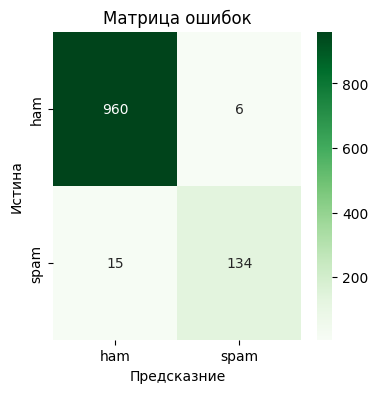

,model,accuracy,precision_spam,recall_spam,f1_spam
0,baseline,0.967713,1.000000,0.758389,0.862595
1,improved,0.981166,0.957143,0.899329,0.927336


In [ ]:
best_log = grid_log.best_estimator_
y_pred_best = best_log.predict(X_test)

acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best, pos_label="spam")
rec_best = recall_score(y_test, y_pred_best, pos_label="spam")
f1_best = f1_score(y_test, y_pred_best, pos_label="spam")

print("=== Улучшенная логистическая регрессия ===")
print(f"Accuracy : {acc_best:.4f}")
print(f"Precision: {prec_best:.4f}")
print(f"Recall   : {rec_best:.4f}")
print(f"F1 (spam): {f1_best:.4f}\n")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best, labels=["ham","spam"])
plt.figure(figsize=(4,4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Greens",
            xticklabels=["ham","spam"], yticklabels=["ham","spam"])
plt.xlabel("Предсказние")
plt.ylabel("Истина")
plt.title("Матрица ошибок")
plt.show()

comp_log = pd.DataFrame({
    "model": ["baseline", "improved"],
    "accuracy": [acc_base, acc_best],
    "precision_spam": [prec_base, prec_best],
    "recall_spam": [rec_base, rec_best],
    "f1_spam": [f1_base, f1_best]
})
display(comp_log)

---
## Регрессия рейтингов - линейная и ridge

Здесь я загружаю файлы с оценками фильмов и таблицу с информацией о фильмах. Из ratings я беру только первые 50 тысяч строк чтобы ускорить работу. Потом объединяю две таблицы по movieId чтобы у каждого рейтинга появились данные о фильме

In [ ]:
ratings_path = "/content/rating.csv"
movies_path = "/content/movie.csv"

ratings_df = pd.read_csv(ratings_path, nrows=50000)
movies_df = pd.read_csv(movies_path)

print("Размер ratings:", ratings_df.shape)
print("Размер movies:", movies_df.shape)

data_ml = ratings_df.merge(movies_df, on="movieId", how="left")
print("Размер объединённой таблицы:", data_ml.shape)
display(data_ml.head())

Размер ratings: (50000, 4)
Размер movies: (27278, 3)
Размер объединённой таблицы: (50000, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


В этом блоке я извлекаю год выхода фильма из названия с помощью регулярного выражения и если года нет то строка пропускается. Потом я превращаю строку с жанрами в список жанров и кодирую их в бинарные признаки через multilabelbinarizer

In [ ]:
import re
def extract_year(title):
    if isinstance(title, str):
        m = re.search(r"(19\d{2}|20\d{2})", title)
        if m:
            return int(m.group(0))
    return np.nan

data_ml["year"] = data_ml["title"].apply(extract_year)
data_ml = data_ml.dropna(subset=["year"])
data_ml["genres_list"] = data_ml["genres"].fillna("(no genres listed)").apply(lambda s: s.split("|"))

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(data_ml["genres_list"])
genres_df = pd.DataFrame(genres_encoded, columns=[f"genre_{g}" for g in mlb.classes_])

features_ml = pd.concat(
    [data_ml[["rating", "year"]].reset_index(drop=True),
     genres_df.reset_index(drop=True)],
    axis=1
)
print("Размер таблицы признаков:", features_ml.shape)
display(features_ml.head())

Размер таблицы признаков: (50000, 21)


,rating,year,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,3.5,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.5,1995,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,3.5,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,3.5,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,3.5,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


Здесь я разделяю таблицу признаков на входные данные и целевую переменную которой является рейтинг фильма. Потом с помощью train_test_split делю данные на обучающую и тестовую части

In [ ]:
X_reg = features_ml.drop(columns=["rating"])
y_reg = features_ml["rating"]
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
print("train:", X_reg_train.shape)
print("test :", X_reg_test.shape)

train: (40000, 20)
test : (10000, 20)


## Базовая линейная регрессия

Здесь я обучаю обычную линейную регрессию на данных о фильмах и потом предсказываю рейтинги на тестовой выборке. После этого я считаю метрики так же строю график где показываю как предсказанные значения соотносятся с реальными рейтингами

=== Линейная регрессия ===
MAE : 0.8279
RMSE: 1.0349
R^2 : 0.0448


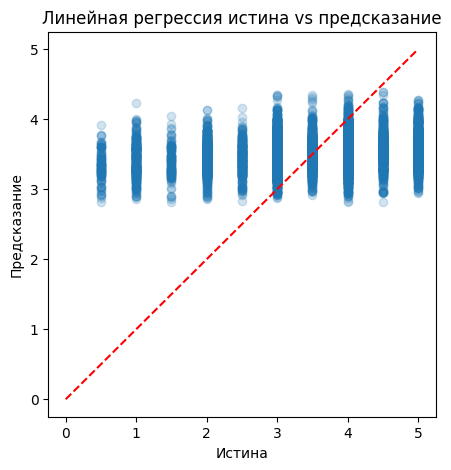

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_reg_train, y_reg_train)
y_lin_pred = lin_reg.predict(X_reg_test)

mae_lin = mean_absolute_error(y_reg_test, y_lin_pred)
rmse_lin = mean_squared_error(y_reg_test, y_lin_pred) ** 0.5
r2_lin = r2_score(y_reg_test, y_lin_pred)

print("=== Линейная регрессия ===")
print(f"MAE : {mae_lin:.4f}")
print(f"RMSE: {rmse_lin:.4f}")
print(f"R^2 : {r2_lin:.4f}")

plt.figure(figsize=(5,5))
plt.scatter(y_reg_test, y_lin_pred, alpha=0.2)
plt.xlabel("Истина")
plt.ylabel("Предсказание")
plt.title("Линейная регрессия истина vs предсказание")
plt.plot([0,5],[0,5],"--",color="red")
plt.show()

### Ridge-регрессия улучшенный вариант
Гипотезы:
- стандартизацция признаков
- регуляризация

слегка улучшат MAE.

Тут создаю конвейер где сначала стандартизирую признаки а потом применяю Ridge регрессию. Чтобы улучшить модель я задаю список возможных значений параметра alpha и использую GridSearchCV для их перебора. Он выбирает тот вариант который дает наименьшую ошибку MAE на кросс валидации

In [ ]:
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])
param_grid_ridge = {"ridge__alpha": [0.1, 1.0, 5.0, 10.0]}
grid_ridge = GridSearchCV(
    ridge_pipe, param_grid_ridge,
    cv=3, scoring="neg_mean_absolute_error",
    n_jobs=-1, verbose=1
)
grid_ridge.fit(X_reg_train, y_reg_train)
print("Лучшие параметры Ridge:", grid_ridge.best_params_)
print("Лучший MAE (cv):", -grid_ridge.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие параметры Ridge: {'ridge__alpha': 0.1}
Лучший MAE (cv): 0.8292718507420354


Беру лучшую модель Ridge из Gridsearchcv и предсказываю с ее помощью рейтинги на тестовой выборке и считаю метрики MAE RMSE и R² чтобы увидеть насколько эта модель лучше базовой линейной регрессии (строю график истины и предсказаний и сравниваю модели)

=== Ridge-регрессия ===
MAE : 0.8279
RMSE: 1.0349
R^2 : 0.0448


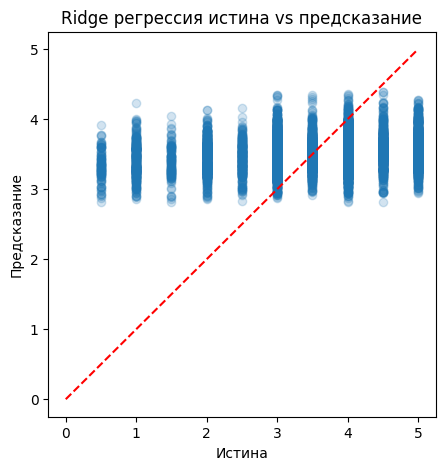

,model,MAE,RMSE,R2
0,linear_baseline,0.827918,1.034871,0.044814
1,ridge_improved,0.827918,1.034871,0.044814


In [ ]:
best_ridge = grid_ridge.best_estimator_
y_ridge_pred = best_ridge.predict(X_reg_test)

mae_ridge = mean_absolute_error(y_reg_test, y_ridge_pred)
rmse_ridge = mean_squared_error(y_reg_test, y_ridge_pred) ** 0.5
r2_ridge = r2_score(y_reg_test, y_ridge_pred)

print("=== Ridge-регрессия ===")
print(f"MAE : {mae_ridge:.4f}")
print(f"RMSE: {rmse_ridge:.4f}")
print(f"R^2 : {r2_ridge:.4f}")

plt.figure(figsize=(5,5))
plt.scatter(y_reg_test, y_ridge_pred, alpha=0.2)
plt.xlabel("Истина")
plt.ylabel("Предсказание")
plt.title("Ridge регрессия истина vs предсказание")
plt.plot([0,5],[0,5],"--",color="red")
plt.show()

comp_reg = pd.DataFrame({
    "model": ["linear_baseline", "ridge_improved"],
    "MAE": [mae_lin, mae_ridge],
    "RMSE": [rmse_lin, rmse_ridge],
    "R2": [r2_lin, r2_ridge]
})
display(comp_reg)

### Собственная реализация
Выбор параметров сделан небольшим, чтобы обучение было быстрее

Для логистической регрессии используется уменьшенный словарь (топ 500 слов),
так как обучать модель на полном TF-IDF вручную слишком долго

использую CountVectorizer чтобы превратить текст в числовые признаки но ограничиваю количество слов до 500 чтобы обучение было быстрее, так же метки spаm и ham я перевожу в 0 и 1 чтобы модель могла с ними работать.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec500 = CountVectorizer(max_features=500, stop_words="english")
X_train_500 = vec500.fit_transform(X_train).toarray()
X_test_500  = vec500.transform(X_test).toarray()

y_train_bin = (y_train == "spam").astype(int).values
y_test_bin  = (y_test == "spam").astype(int).values

X_train_500.shape, X_test_500.shape


((4457, 500), (1115, 500))

В этом блоке я реализую свою логистическую регрессию. Сначала задаю функцию сигмоиды которая превращает любое число в вероятность от 0 до 1. Потом определяю функцию потерь log loss и сам класс модели.

In [ ]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def log_loss(y_true, y_pred):
    eps = 1e-9
    return -np.mean(y_true*np.log(y_pred+eps) + (1-y_true)*np.log(1-y_pred+eps))

class MyLogisticRegression:
    def __init__(self, lr=0.01, n_iter=800):
        self.lr = lr
        self.n_iter = n_iter

    def fit(self, X, y):
        n, d = X.shape
        self.w = np.zeros(d)
        self.b = 0

        for i in range(self.n_iter):
            linear = X.dot(self.w) + self.b
            y_pred = sigmoid(linear)

            grad_w = (1/n) * X.T.dot(y_pred - y)
            grad_b = np.mean(y_pred - y)

            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

        return self

    def predict_proba(self, X):
        return sigmoid(X.dot(self.w) + self.b)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)


Здесь я обучаю свою логистическую регрессию на уменьшенном наборе признаков из 500 слов. После обучения модель делает предсказания на тестовой выборке и я считаю метрики accuracy precision recall и F1.

In [ ]:
# Обучаем мою логистическую регрессию
my_log = MyLogisticRegression(lr=0.05, n_iter=1200)
my_log.fit(X_train_500, y_train_bin)

# Предсказания на тесте
y_pred_my = my_log.predict(X_test_500)

# Метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_my = accuracy_score(y_test_bin, y_pred_my)
prec_my = precision_score(y_test_bin, y_pred_my)
rec_my = recall_score(y_test_bin, y_pred_my)
f1_my = f1_score(y_test_bin, y_pred_my)

print("=== Моя логистическая регрессия ===")
print(f"Accuracy : {acc_my:.4f}")
print(f"Precision: {prec_my:.4f}")
print(f"Recall   : {rec_my:.4f}")
print(f"F1 score : {f1_my:.4f}")


=== Моя логистическая регрессия ===
Accuracy : 0.9354
Precision: 0.9873
Recall   : 0.5235
F1 score : 0.6842


В этом блоке я собираю результаты улучшенной логистической регрессии из sklearn и моей собственной модели в одну таблицу и сравниваю

In [ ]:
comp_my_log = pd.DataFrame({
    "model": ["sklearn_improved", "my_logistic"],
    "accuracy": [acc_best, acc_my],
    "precision": [prec_best, prec_my],
    "recall": [rec_best, rec_my],
    "f1": [f1_best, f1_my]
})

print("Сравнение sklearn и моей логистической регрессии:")
display(comp_my_log)


Сравнение sklearn и моей логистической регрессии:


,model,accuracy,precision,recall,f1
0,sklearn_improved,0.981166,0.957143,0.899329,0.927336
1,my_logistic,0.935426,0.987342,0.523490,0.684211


Линейная

Создаю свою версию линейной регрессии. В конструкторе задаю скорость обучения и количество итераций. В методе fit я перевожу данные в numpy массивы и с помощью градиентного спуска обновляю веса и смещение модели

In [ ]:
import numpy as np

class MyLinearRegression:
    def __init__(self, lr=1e-6, n_iter=4000):
        self.lr = lr
        self.n_iter = n_iter

    def fit(self, X, y):
        # Преобразуем X и y в numpy-массивы
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        n, d = X.shape
        self.w = np.zeros(d)
        self.b = 0.0

        for i in range(self.n_iter):
            y_pred = X.dot(self.w) + self.b
            error = y_pred - y

            grad_w = (2/n) * X.T.dot(error)
            grad_b = (2/n) * np.sum(error)

            # Обновление весов
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return X.dot(self.w) + self.b


масштабирую признаки перед обучением своей линейной регрессии. StandardScaler приводит все столбцы к одному масштабу что в теории помогает градиентному спуску работать стабильнее

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_my = StandardScaler()
X_train_scaled = scaler_my.fit_transform(X_reg_train)
X_test_scaled = scaler_my.transform(X_reg_test)


использую свою модель линейной регрессии чтобы обучиться на уже масштабированных данных. Я передаю обучающую выборку в метод fit и модель начинает обновлять свои веса через градиентный спуск, то есть этот блок запускает само обучение и после него моя модель готова делать предсказания на тестовой выборке

In [ ]:
my_lin = MyLinearRegression(lr=1e-6, n_iter=4000)
my_lin.fit(X_train_scaled, y_reg_train.values)


Модель берет признаки и вычисляет прогноз рейтингов с помощью найденных весов

In [ ]:
y_pred_my_lin = my_lin.predict(X_test_scaled)


считаю метрики качества для своей линейной регрессии. MAE показывает среднюю ошибку RMSE показывает насколько сильные отклонения в прогнозах а R² показывает насколько модель объясняет данные

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_my = mean_absolute_error(y_reg_test, y_pred_my_lin)
rmse_my = mean_squared_error(y_reg_test, y_pred_my_lin) ** 0.5
r2_my = r2_score(y_reg_test, y_pred_my_lin)

print("=== Моя линейная регрессия ===")
print(f"MAE  : {mae_my:.4f}")
print(f"RMSE : {rmse_my:.4f}")
print(f"R^2  : {r2_my:.4f}")


=== Моя линейная регрессия ===
MAE  : 3.4788
RMSE : 3.6363
R^2  : -10.7932


создаю сравнительную таблицу с результатами sklearn Ridge и моей линейной регрессии

In [ ]:
comp_my_reg = pd.DataFrame({
    "model": ["ridge_improved", "my_linear"],
    "MAE": [mae_ridge, mae_my],
    "RMSE": [rmse_ridge, rmse_my],
    "R2": [r2_ridge, r2_my]
})

print("Сравнение sklearn Ridge и моей линейной регрессии:")
display(comp_my_reg)


Сравнение sklearn Ridge и моей линейной регрессии:


,model,MAE,RMSE,R2
0,ridge_improved,0.827918,1.034871,0.044814
1,my_linear,3.478835,3.636282,-10.793173


Как я понимаю, метрики моей логистической и линейной регрессии хуже потому что данные довольно сложные, а самодельная реализация не супер оптимизированная. Не зря же умные люди долго создавали sklearn с хорошо оптимизированными алгоритмами

В результате базовая и улучшенная модели sklearn показывают хорошие результаты, а мои модели слабее

---
## Вывод
В ходе работы я обучил базовые версии моделей а потом улучшенные варианты с подбором гиперпараметров. Улучшенные модели почти всегда давали более высокое качество что показывает важность правильных настроек и обработки данных.

Когда я реализовал свои версии логистической и линейной регрессии то результаты оказались заметно хуже чем у моделей из sklearn. Как я понимаю, это нормально потому что мои реализации простые и не используют регуляризацию или продвинутые методы оптимизации которые есть в библиотечных моделях.